# Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [2]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

## Find outliers (NaN & 0 for USAGE_KWH) and replace using linear interpolation
### Original Idea: Converts all USAGE_KWH values less than 5 into nans, which are replaced using linear interpolation- necessary for boxcox transform


In [3]:
weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    # Removing values that are 0 allows boxcox to perform transformation
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


### I chose not to modify the following cell's code because it is common to use the preinstalled "seasonal_decompose" function to analyze different qualities about the data

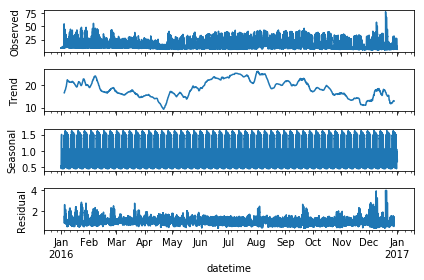

In [4]:
# Code obtained from (https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
from matplotlib import pyplot
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
original_df = pd.Series(data.iloc[:,0])
result = seasonal_decompose(original_df, model='multiplicative',freq=672)
result.plot()
pyplot.show()

### Modified Code: I use the same function but iterate through the different transformations of data to see what changes maximize stationarity

In [19]:
# The ADFuller test to determine stationarity. Run this AFTER creating the lists: diff, outcome, and diff2. 
# This cell is placed here merely to indicate its importance overall when deciding what data transformations to use.
# The code is from (https://machinelearningmastery.com/time-series-data-stationary-python/)

from pandas import Series
from statsmodels.tsa.stattools import adfuller

orig_data = data.iloc[:,0]
orig_diff = pd.DataFrame(diff)
box_data = pd.DataFrame(outcome)
box_diff = pd.DataFrame(meta_diff)

index = 0
datas = [orig_data,orig_diff, box_data,box_diff]
for item in datas:
    index+=1
    print(index)
    X = item.values.reshape(len(item))
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

1
ADF Statistic: -19.643064
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
2
ADF Statistic: -16.073426
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
3
ADF Statistic: -20.089293
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
4
ADF Statistic: -16.940690
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Original Idea: Replacing NaN values with linear interpolation to make coint johansen test work

In [6]:
# Code from https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Replacing nan values with linear interpolation
for num in range(data.shape[1]):
    data.iloc[:,num] = data.iloc[:,num].interpolate(method='linear')
    print(sum(np.isnan(x) for x in data.iloc[:,num]))
    
coint_johansen(data,-1,1).eig

0
0
0
0
0
0
0


array([6.80903996e-02, 3.40066981e-02, 3.12719387e-02, 1.40448097e-02,
       3.91871933e-03, 8.46858376e-04, 6.70153190e-06])

## Removing Seasonality Through Differing

### The Difference function was not modified because no improvements were necessary to accomplish the desired task

### I created a custom function (find_intervals) to find the Median Difference of Peak Indexes in the USAGE_KWH 

In [7]:
import statistics

# code obtained from: https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Original Code

# Helps find what interval value to use when using differencing 

def find_intervals(data, interval):
    list_indexes = []
    index = 0
    for item in data.iloc[:,0]:
        if item > interval and data.iloc[index-2,0] <interval and data.iloc[index+2,0] <interval:
            list_indexes.append(index)
        index+=1

    final_list = []
    index = 0
    for item in list_indexes:
        try:
            if abs(item-list_indexes[index+1]) > 30:
                final_list.append(item)
        except:
            pass
        index+=1
    meta_diff = difference(final_list,1)
    return(statistics.median(meta_diff),statistics.mean(meta_diff))

In [8]:
print("The first value is the median. The second is the mean (not reliable because the distribution is skewed)")
print(find_intervals(data,40))
print(find_intervals(data,35))
print(find_intervals(data,30))

The first value is the median. The second is the mean (not reliable because the distribution is skewed)
(287, 824.9230769230769)
(198, 473.49295774647885)
(148, 229.17006802721087)


### I created a custom function (invert_diff) that inverts a set of numbers that have been differenced
### The blog's invert_difference function was not sufficient, so I improved on their work

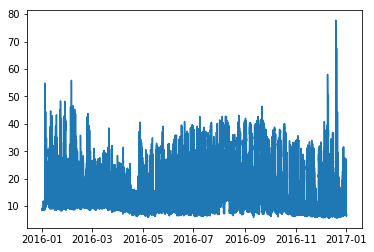

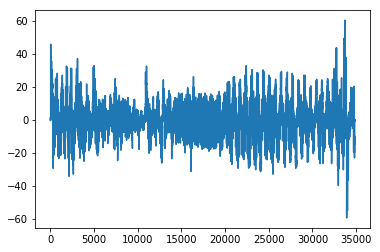

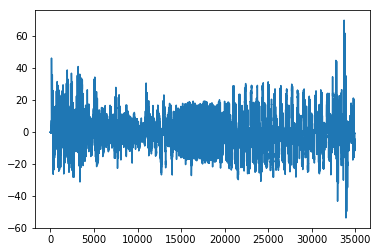

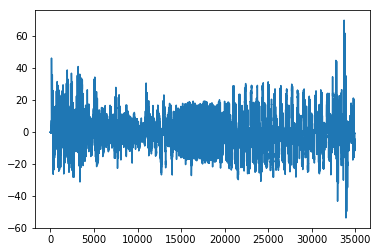

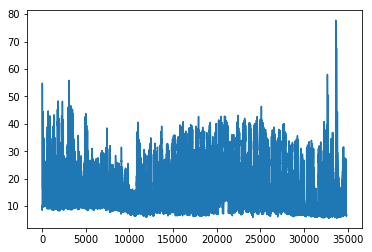

In [9]:
# Graphing the effects of differencing on the data using Median values obtained above
from matplotlib import pyplot

# Original Code
# create a differenced series 
def invert_diff(predictions,past_value):
    new_preds=[]
    for item in range(len(predictions)):
        temp = predictions[item] + past_value[item]
        new_preds.append(temp)
    return new_preds

# code from https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/
def inverse_difference(last_ob, value):
	return value + last_ob

# code from https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/
# define a dataset with a linear trend
pyplot.plot(data.iloc[:,0])
pyplot.show()
# difference the dataset
diff = difference(data.iloc[:,0],290)
pyplot.plot(diff)
pyplot.show()
diff2 = difference(data.iloc[:,0],200)
pyplot.plot(diff2)
pyplot.show()
diff3 = difference(data.iloc[:,0],150)
pyplot.plot(diff2)
pyplot.show()
# invert the difference
inverted = [inverse_difference(data.iloc[:,0][i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

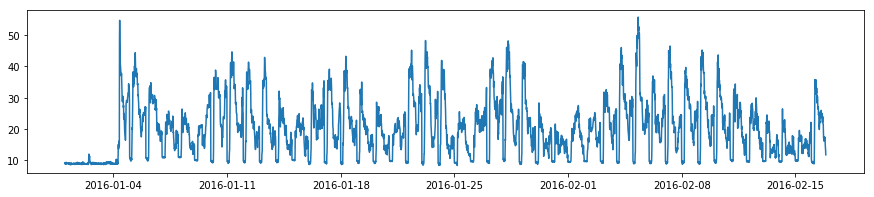

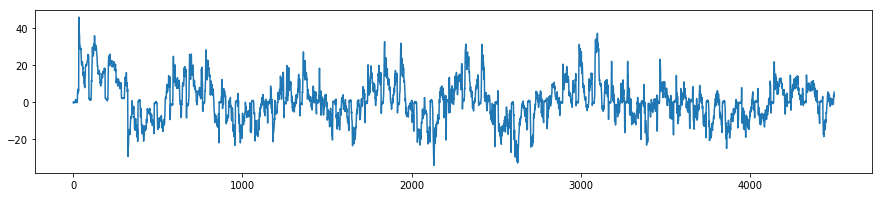

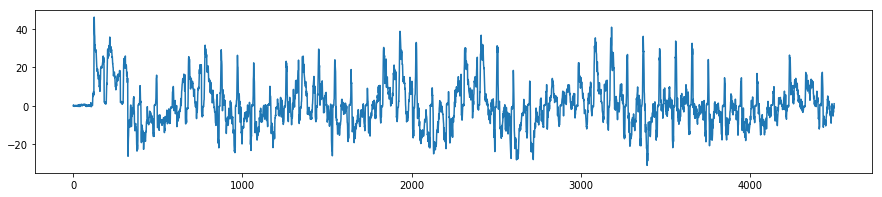

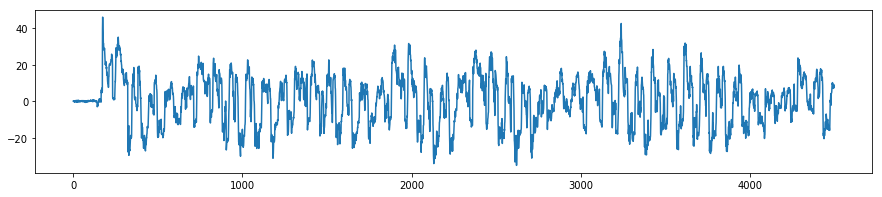

In [10]:
# Seeing the first 4500 values in each differenced list (4500 allows for zooming in and understand seasonality better)

pyplot.figure(figsize=(15, 3))
pyplot.plot(data.iloc[:4500,0])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(diff[:4500])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(diff2[:4500])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(diff3[:4500])
pyplot.show()

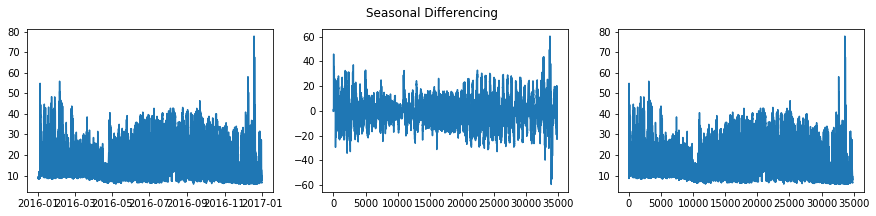

In [11]:
# Visualizing before and after differencing
pyplot.figure(figsize=(15, 3))
pyplot.subplot(131)
pyplot.plot(data.iloc[:,0])
pyplot.subplot(132)
pyplot.plot(diff)
pyplot.subplot(133)
pyplot.plot(inverted)
pyplot.suptitle('Seasonal Differencing')
pyplot.show()

## BoxCox Transformation

### No modification of original code was needed

In [13]:
# code obtained from https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/

from scipy.stats import boxcox

outcome, lmbda = boxcox(data.iloc[:,0])
print(lmbda)
print(np.max(data.iloc[:,0]))
print(np.max(outcome))

0.16848968115958027
77.75
6.424113843751646


### Code was not modified from source because it was exactly what was needed to visualize the frequency of the USAGE_KWH values

Lambda: 0.168490


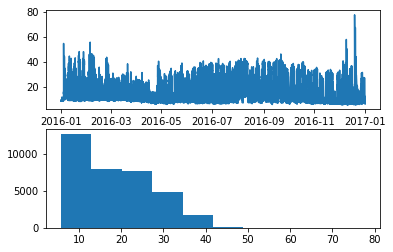

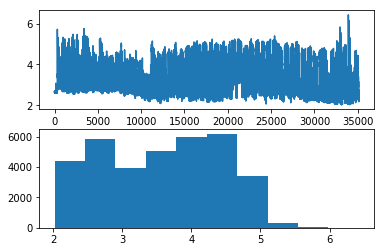

In [14]:
# Illustrate the normalization effect boxcox has on the frequency of USAGE_KWH values

# Code from https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/
from matplotlib import pyplot

print('Lambda: %f' % lmbda)
# line plot
pyplot.subplot(211)
pyplot.plot(data.iloc[:,0])
# histogram
pyplot.subplot(212)
pyplot.hist(data.iloc[:,0])
pyplot.show()

pyplot.subplot(211)
pyplot.plot(outcome)
# histogram
pyplot.subplot(212)
pyplot.hist(outcome)
pyplot.show()

## Find effect of differencing on a difference-transformed dataset

### I created a custom function (find_intervals) to find the Median Difference of Peak Indexes in the USAGE_KWH 

In [15]:
# Original Code
# Find the Median Difference of Peak Indexes in the USAGE_KWH after Differencing transformation
# Helps find what interval value to use when using differencing

import statistics
def find_diff_intervals(data, pos_interval,neg_interval):
    list_indexes = []
    index = 0
    for item in data:
        if item > pos_interval and data[index-2] <pos_interval and data[index+2] <pos_interval:
            list_indexes.append(index)
        elif item < neg_interval and data[index-2] > neg_interval and data[index+2] > neg_interval:
            list_indexes.append(index)
        index+=1

    final_list = []
    index = 0
    for item in list_indexes:
        try:
            if abs(item-list_indexes[index+1]) > 30:
                final_list.append(item)
        except:
            pass
        index+=1
    meta_diff = difference(final_list,1)
    return(statistics.median(meta_diff),statistics.mean(meta_diff))

In [16]:
print(find_diff_intervals(diff2,25,-20))
print(find_diff_intervals(diff2,20,-20))
print(find_diff_intervals(diff2,15,-20))

print(find_diff_intervals(diff2,25,-15))
print(find_diff_intervals(diff2,20,-15))
print(find_diff_intervals(diff2,15,-15))

(188, 427.36708860759495)
(138.5, 320.39814814814815)
(105.5, 193.07303370786516)
(172, 255.62222222222223)
(128.0, 213.97530864197532)
(101.0, 160.00925925925927)


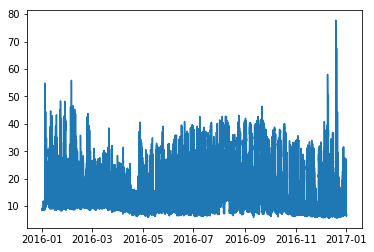

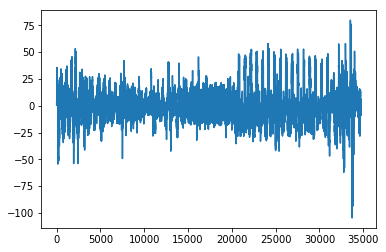

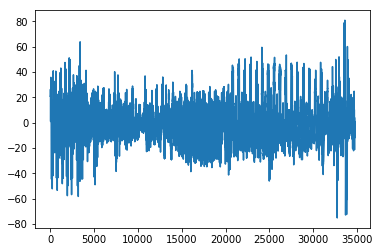

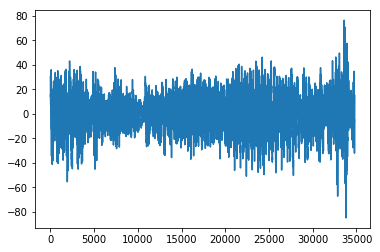

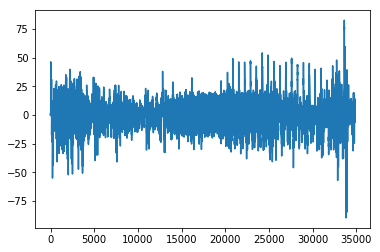

In [17]:
# code from https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

# define a dataset with a linear trend
pyplot.plot(data.iloc[:,0])
pyplot.show()
# difference the dataset
meta_diff = difference(diff2,190)
pyplot.plot(meta_diff)
pyplot.show()

meta_diff2 = difference(diff2,170)
pyplot.plot(meta_diff2)
pyplot.show()

meta_diff3 = difference(diff2,130)
pyplot.plot(meta_diff3)
pyplot.show()

meta_diff4 = difference(diff2,100)
pyplot.plot(meta_diff4)
pyplot.show()

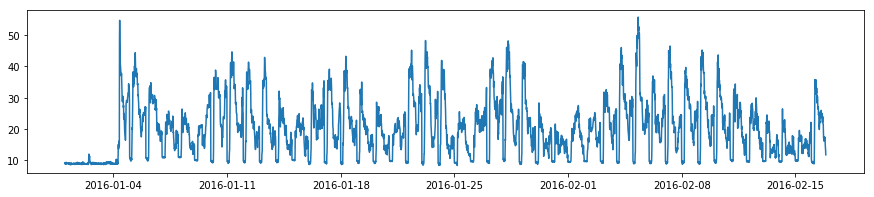

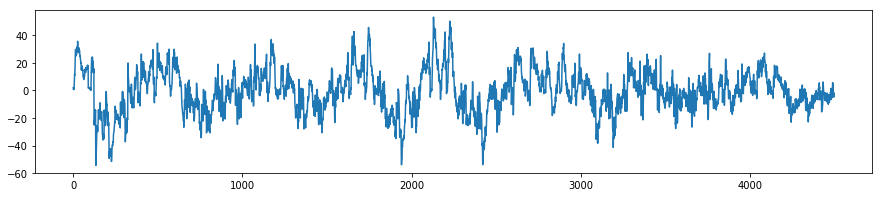

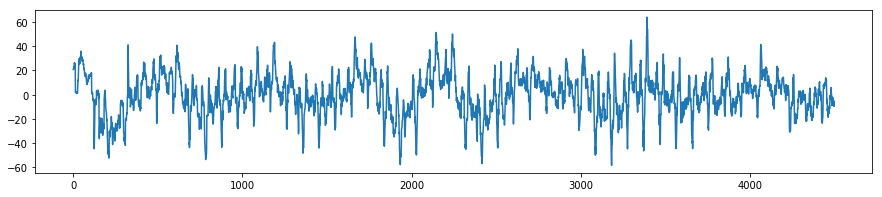

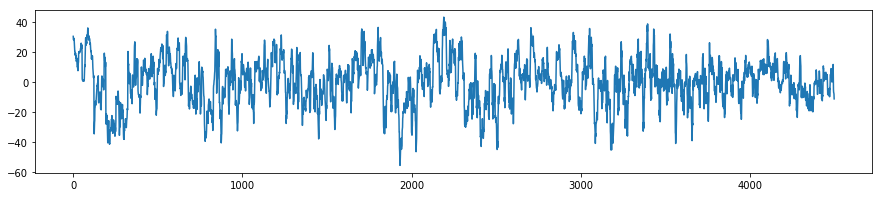

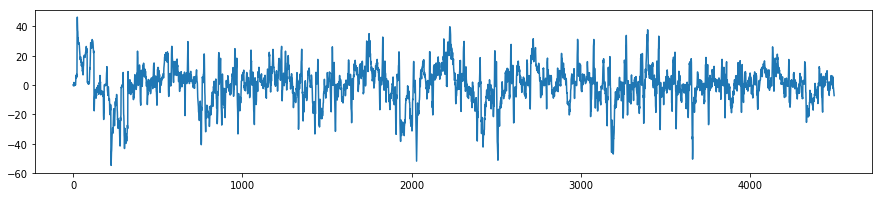

In [18]:
# code from https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

pyplot.figure(figsize=(15, 3))
pyplot.plot(data.iloc[:4500,0])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(meta_diff[:4500])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(meta_diff2[:4500])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(meta_diff3[:4500])
pyplot.show()

pyplot.figure(figsize=(15, 3))
pyplot.plot(meta_diff4[:4500])
pyplot.show()

# Note: It is useful to now go back to the AD Fuller and Coint Johanson Code (5th cell) to see the test results on all 4 datasets

# Prelimarnary Visualization

### Code was not modified from source because it is common practice to create a lagged dataframe before using the prebuilt corr function

C:\Derek\AIProject\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


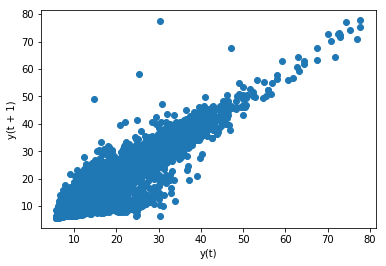

          t-1       t+1
t-1  1.000000  0.977869
t+1  0.977869  1.000000


In [20]:
# Lagplot for correlation over adjacent points (Original data)
# Code from https://machinelearningmastery.com/time-series-data-visualization-with-python/

from pandas import DataFrame
from pandas import concat
from pandas.tools.plotting import lag_plot

lag_plot(data['USAGE_KWH'])
pyplot.show()

values = DataFrame(data['USAGE_KWH'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

## Original Idea: use lagplot and correlation coefficients on a transformed dataset

C:\Derek\AIProject\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


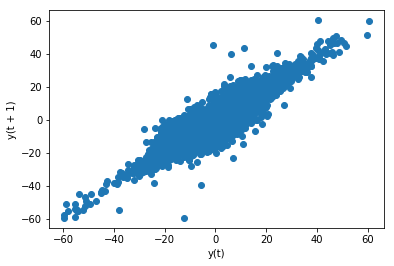

          t-1       t+1
t-1  1.000000  0.960073
t+1  0.960073  1.000000


In [21]:
# Lagplot over time (Differenced data) and Correlation Coefficients
new_df = pd.DataFrame(diff)
lag_plot(new_df)
pyplot.show()

values = DataFrame(new_df.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

## Original Idea: use lagplot and correlation coefficients on a transformed dataset

C:\Derek\AIProject\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


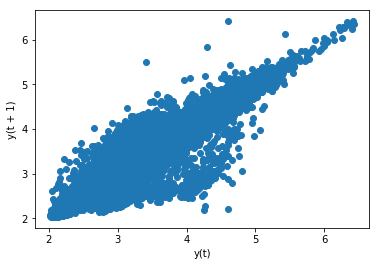

          t-1       t+1
t-1  1.000000  0.978044
t+1  0.978044  1.000000


In [23]:
# Lagplot over time (Differenced data) and Correlation Coefficients
new_df2 = pd.DataFrame(outcome)
lag_plot(new_df2)
pyplot.show()

values = DataFrame(new_df2.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

### Code was not modified from source because it is a common practice to use plot_acf on a pandas series object to see the autocorrelation

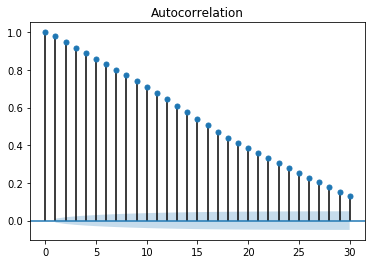

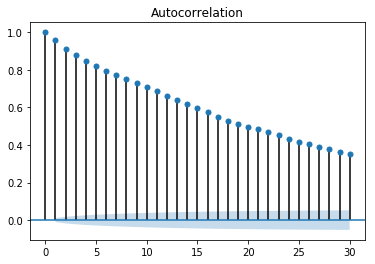

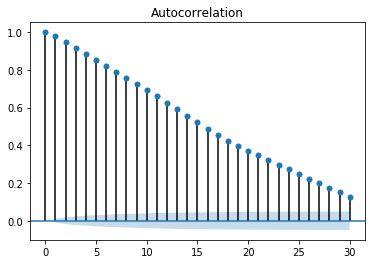

In [24]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
# code from http://www.statsmodels.org/devel/generated/statsmodels.graphics.tsaplots.plot_acf.html

plot_acf(data['USAGE_KWH'], lags=30)
pyplot.show()

plot_acf(new_df, lags=30)
pyplot.show()

plot_acf(new_df2, lags=30)
pyplot.show()

## Original Idea: use boxplots to analyze data distribution

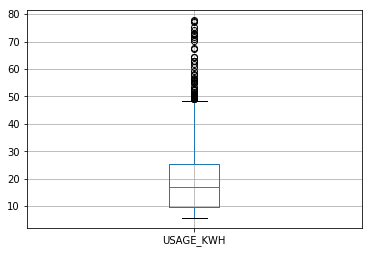

In [25]:
# Original Code
# Understand USAGE_KWH distribution
boxplot_usage = data.boxplot(column=["USAGE_KWH"])
boxplot_usage

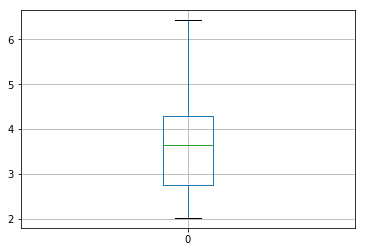

In [27]:
# Understand USAGE_KWH distribution
boxplot_usage_box = new_df2.boxplot()
boxplot_usage

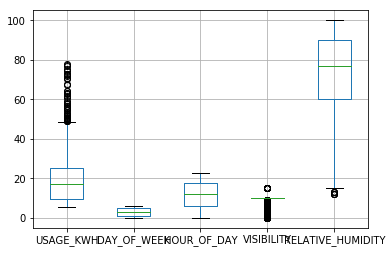

In [28]:
# Original Code
# Understand other variables' distributions
boxplot = data.boxplot(column=["USAGE_KWH", "DAY_OF_WEEK",'HOUR_OF_DAY','VISIBILITY','RELATIVE_HUMIDITY'])
boxplot

# Original Idea: Seasonal Decomposition may produce clearer results after downsampling the data

In [29]:
# Original Code


data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])
values = data.iloc[:,0]

weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    # Removing values that are 0 allows boxcox to perform transformation
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

hours = values.resample('H').mean()
days = values.resample('D').mean()
weeks = values.resample('W').mean()

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


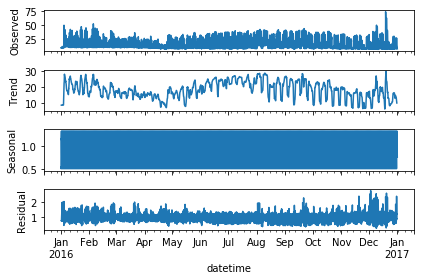

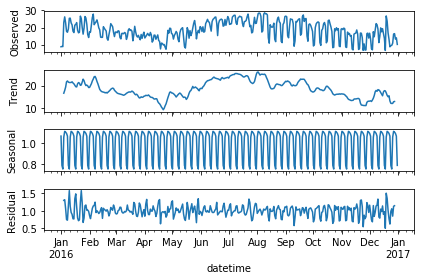

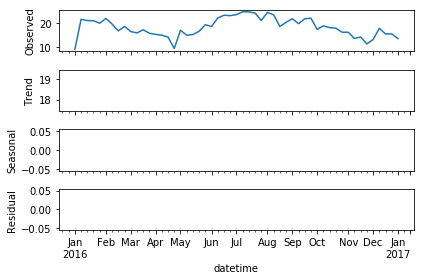

In [30]:
# Code obtained from (https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

from statsmodels.tsa.seasonal import seasonal_decompose

orig_df_hours = pd.Series(hours)
result = seasonal_decompose(orig_df_hours, model='multiplicative')
result.plot()
pyplot.show()


orig_df_days = pd.Series(days)
result = seasonal_decompose(orig_df_days, model='multiplicative')
result.plot()
pyplot.show()

orig_df_week = pd.Series(weeks)
result = seasonal_decompose(orig_df_week, model='multiplicative')
result.plot()
pyplot.show()

# Original Idea: Decomposition may be more clear after boxcox transformation and downsampling

In [31]:
# Original Code
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
box_data_dict = {'USAGE_KWH':outcome}
box_data = pd.DataFrame(box_data_dict)
data.iloc[:,1] = box_data # changes original usage_kwh data to box data 
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])
values = data.iloc[:,0]

hours = values.resample('H').mean()
days = values.resample('D').mean()
weeks = values.resample('W').mean()

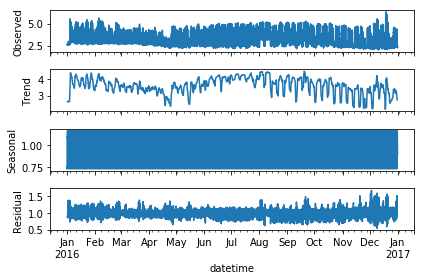

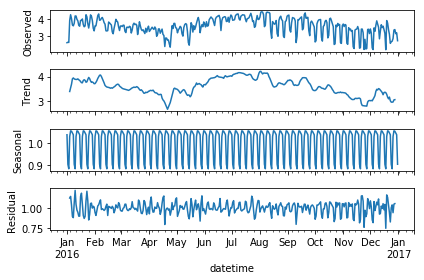

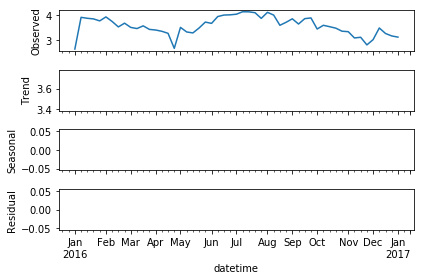

In [32]:
# Code obtained from (https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

from statsmodels.tsa.seasonal import seasonal_decompose

box_df_hours = pd.Series(hours)
result = seasonal_decompose(box_df_hours, model='multiplicative')
result.plot()
pyplot.show()


box_df_days = pd.Series(days)
result = seasonal_decompose(box_df_days, model='multiplicative')
result.plot()
pyplot.show()

box_df_week = pd.Series(weeks)
result = seasonal_decompose(box_df_week, model='multiplicative')
result.plot()
pyplot.show()

# Original Idea: Resampling (Downsampling) to visualize data on a daily, weekly, or monthly frequency

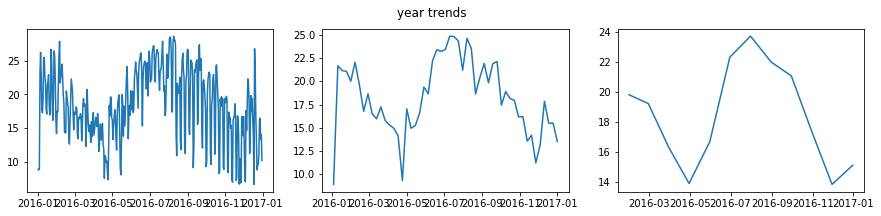

In [33]:
# Original Code
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])
values = data.iloc[:,0]

days = values.resample('D').mean()
weeks = values.resample('W').mean()
months = values.resample('M').mean()

pyplot.figure(figsize=(15, 3))
pyplot.subplot(131)
pyplot.plot(days)
pyplot.subplot(132)
pyplot.plot(weeks)
pyplot.subplot(133)
pyplot.plot(months)
pyplot.suptitle('year trends')
pyplot.show()

# Original Idea: Downsampling Data after Differencing was Applied (To remove seasonality)

In [34]:
# Original Code
indexes = data.index

d = {'diff': pd.Series(diff),
    'datetime': pd.Series(indexes)}
temp_df = pd.DataFrame(d)
temp_df = temp_df.set_index(['datetime'])
temp_df.index = pd.to_datetime(temp_df.index)

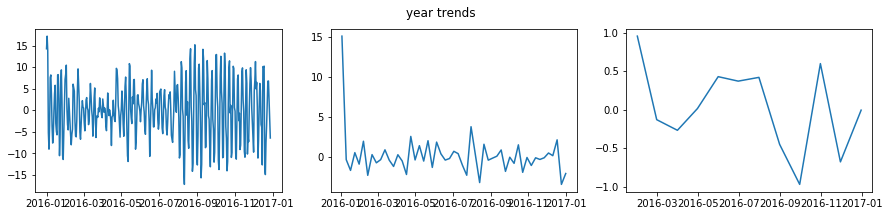

In [35]:
# Original Code
days = temp_df.resample('D').mean()
weeks = temp_df.resample('W').mean()
months = temp_df.resample('M').mean()
pyplot.figure(figsize=(15, 3))
pyplot.subplot(131)
pyplot.plot(days)
pyplot.subplot(132)
pyplot.plot(weeks)
pyplot.subplot(133)
pyplot.plot(months)
pyplot.suptitle('year trends')
pyplot.show()

# Original Idea: See Distribution of USAGE_KWH for all days in every month

In [36]:
month_list = {}

months = [1,32,61,92,122,153,183,214,245,275,306,336,367]
index = 0
for item in months:
    per_month=pd.DataFrame()
    if index==12:
        index=11
    for a in range(1,96*(months[index+1]-item)):
        try:
            per_month = per_month.append(data.iloc[(item-1)*96+a])
        except:
            print(index)
    month_list["month{0}".format(index)]=per_month
    index+=1

11


(2975, 1)


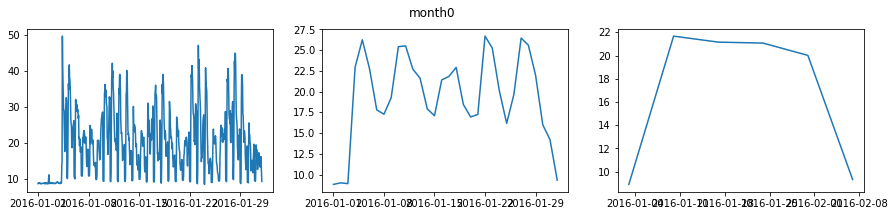

(2783, 1)


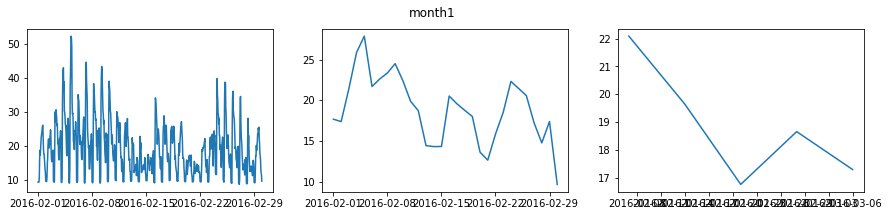

(2975, 1)


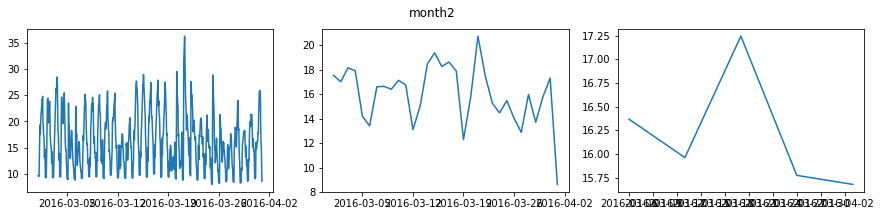

(2879, 1)


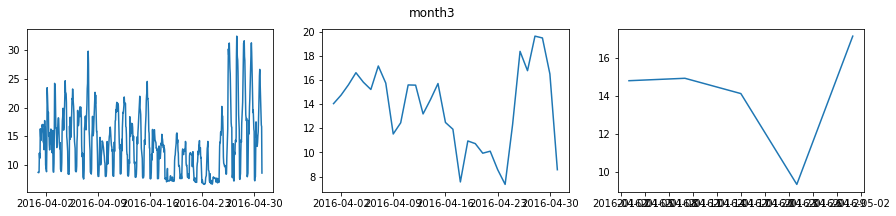

(2975, 1)


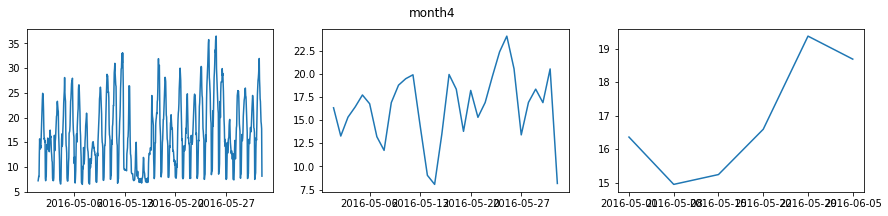

(2879, 1)


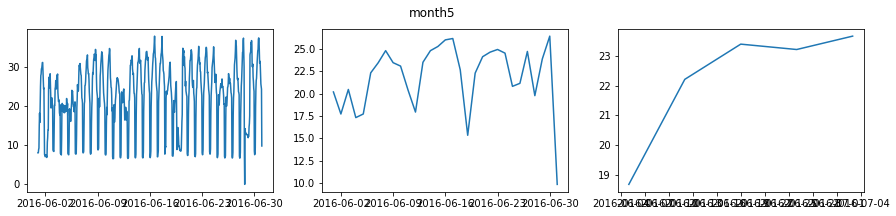

(2975, 1)


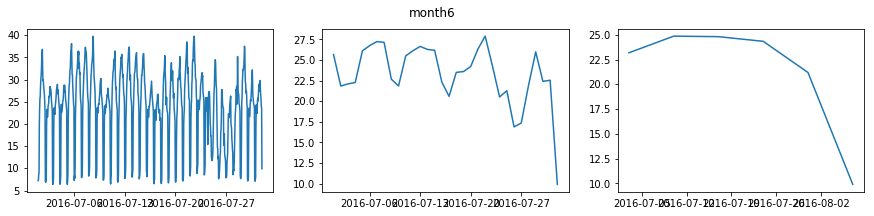

(2975, 1)


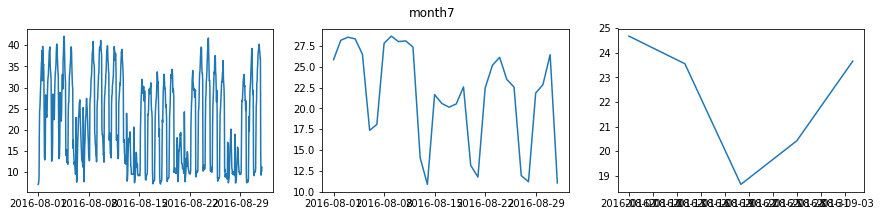

(2879, 1)


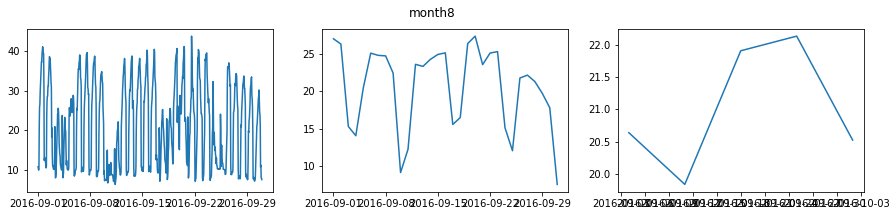

(2975, 1)


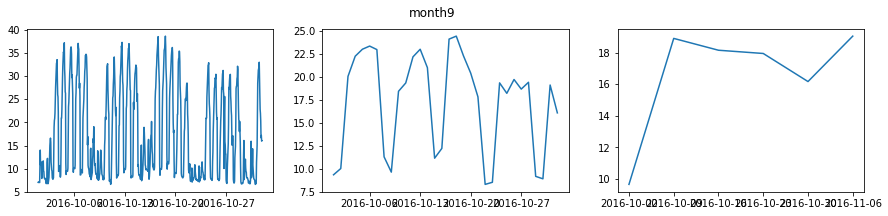

(2879, 1)


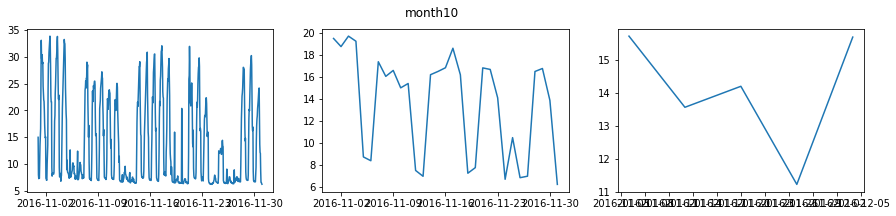

In [38]:
#months = [J, F, M, A, M,  J,  J,  A,  S,  O,  N,  D]
months = [1,32,61,92,122,153,183,214,245,275,306,336]
months_index = [0,1,2,3,4,5,6,7,8,9,10]
for item in months_index:
    df = pd.DataFrame(month_list["month%s" %item].iloc[:,5])
    print(df.shape)
    hours2 = df.resample('H').mean()
    days2 = df.resample('D').mean()
    weeks2 = df.resample('W').mean()
    
    
    pyplot.figure(figsize=(15, 3))
    pyplot.subplot(131)
    pyplot.plot(hours2)
    pyplot.subplot(132)
    pyplot.plot(days2)
    pyplot.subplot(133)
    pyplot.plot(weeks2)
    pyplot.suptitle('month%s'%item)
    pyplot.show()